### Created by: Anthony D. Cho
### Last update: 25.12.2021

**Subject**: FeatureMap Visualization (InceptionV3 - keras, tensorflow)

## Libraries dependencies

In [1]:
import matplotlib.pyplot as plt
from numpy import clip, zeros

## keras tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

## Customized functions

In [2]:
def compute_loss(input_image, model, filter_index):
    """
        DESCRIPTION:
            Compute the mean of the activation of a specific filter in our target layer.
            From keras - FChollet

        INPUT:
            @param input_image: input image
            @type input_image: numpy.ndarray

            @param model: Convolutional neural network model for feature extraction
            @type model: tensorflow.keras.models.functional

            @param filter_index: filter index
            @type filter_index: int

        OUTPUT:
            @param loss: loss function value
            @type loss: float
    """

    ## Compute activation maps    
    activation = model(input_image)
    print('(Shape) layer output: {}'.format(activation.shape))

    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]

    ## Compute loss function value
    loss = tf.reduce_mean(filter_activation)

    ## return loss value
    return loss

@tf.function
def gradient_ascent_step(img, model, filter_index, learning_rate):
    """
        DESCRIPTION:
            Compute the gradients of the loss-value with regard to the input image, 
            and update the image so as to move it towards a state that will activate 
            the target filter more strongly.
            From keras - FChollet

        INPUT:
            @param img: image array
            @type img: numpy.ndarray

            @param model: Convolutional neural network model for feature extraction
            @type model: tensorflow.keras.models.functional

            @param filter_index: filter index
            @type filter_index: int

            @param learning_rate: learning rate of the gradient ascent
            @type learning_rate: float

        OUTPUT:
            @param loss: loss function value
            @type loss: float

            @param img: updated image array
            @type img: numpy.ndarray
        
    """

    with tf.GradientTape() as tape:

        ## Gradient objective fixed at image
        tape.watch(img)

        ## Compute loss function 
        loss = compute_loss(img, model, filter_index)

    # Compute gradients.
    gradients = tape.gradient(loss, img)

    # Normalize gradients.
    gradients = tf.math.l2_normalize(gradients)

    ## Update image applying gradient ascent
    img += learning_rate * gradients

    ## return gradients and updated image
    return loss, img

In [3]:
def initialize_image(width=180, height=180):
    """
        DESCRIPTION:
            Create a gray image with 3 channels with noise

        INPUT:
            @param width: image width (default 180)
            @type width: int

            @param height: image height (default 180)
            @type height: int

        OUTPUT:
            @param img: image tensor
            @type img: tensorflow.tensor
        
    """
    ## Image building
    img = tf.random.uniform((1, width, height, 3))

    ## Image scaling: Here we scale our random inputs to [-0.125, +0.125]
    img = (img - 0.5) * 0.25

    ## return image
    return img

def deprocess_image(img):
    """
        DESCRIPTION:
            Tensor decoding to 255 scale.

        INPUT:
            @param img: image array
            @type img: tensorflow.tensor

        OUTPUT:
            @param img: decoded image array
            @type img: tensorflow.tensor
        
    """
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = clip(img, 0, 255).astype("uint8")

    ## return decoded image
    return img

def visualize_filter(model, filter_index, 
                     width=180, height=180,
                     iterations=30, learning_rate=10.0):
    """
        DESCRIPTION:
            Filter visualizer function

        INPUT:
            @param model: Convolutional neural network model for feature extraction
            @type model: tensorflow.keras.models.functional

            @param filter_index: filter index
            @type filter_index: int

            @param width: image width (default 180)
            @type width: int

            @param height: image height (default 180)
            @type height: int

            @param iterations: number of iterations to apply gradient ascent (default 30)
            @type iterations: int

            @param learning_rate: learning rate of the gradient ascent (default 10.0)
            @type learning_rate: float

        OUTPUT:
            @param loss: loss function value
            @type loss: float

            @param img: Feature map response image
            @type img: numpy.ndarray
        
    """

    ## Image instance
    img = initialize_image(width, height)

    ## Run gradient ascent iterations
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, model, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())

    ## return loss function value and feature map response image
    return loss, img


## Execution

In [4]:
## input image size
img_width, img_height = 180, 180

## Load Pre-trained model
base = InceptionV3(weights="imagenet", include_top=False)
base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [5]:
## Layer selection
layer_name = 'mixed1'

# Set up a model that returns the activation values for our target layer
layer = base.get_layer(name=layer_name)
model = Model(inputs=base.inputs, outputs=layer.output)


In [6]:
loss, img = visualize_filter(model=model, filter_index=0, 
                             width=180, height=180,
                             iterations=30, learning_rate=10.0)

## display image shape
img.shape

(Shape) layer output: (1, 20, 20, 288)


(130, 130, 3)

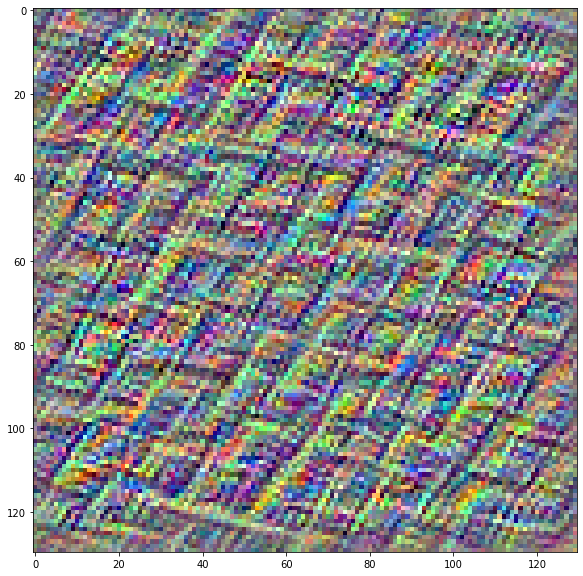

In [7]:
## Feature map response display
plt.figure(figsize=(10, 10))
plt.imshow(img/255.0); plt.show()

### Visualize the first N filters in the target layer

In [8]:
## Number of filters to visualize
N = 64

# Compute image inputs that maximize per-filter activations
# for the first N filters of our target layer
all_images = []
print('Processing Filter:')
for filter_index in range(N):
    print(filter_index, end=' ')

    ## Compute feature maps image response
    _, img = visualize_filter(model=model, filter_index=filter_index, 
                              width=img_width, height=img_height,
                              iterations=30, learning_rate=10.0)

    ## Store image in list
    all_images.append(img)

# Build a black picture with enough space for
# our feature maps image, with a 5px margin in between
margin = 5
ncol = 8
nrow = int(N // ncol +1) if N%ncol else int(N // ncol)
cropped_width, cropped_height = img.shape[:2]
width = ncol * cropped_width + (ncol - 1) * margin
height = nrow * cropped_height + (nrow - 1) * margin
stitched_filters = zeros((height, width, 3))

# Fill the picture with our saved filters
for i in range(nrow):
    for j in range(ncol):
        index = i * ncol + j
        if index < N:
            img = all_images[index]
            stitched_filters[
                (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
                (cropped_height + margin) * j : (cropped_height + margin) * j
                + cropped_height,
                :,
            ] = img

Processing Filter:
0 1 (Shape) layer output: (1, 20, 20, 288)
2 (Shape) layer output: (1, 20, 20, 288)
3 (Shape) layer output: (1, 20, 20, 288)
4 (Shape) layer output: (1, 20, 20, 288)
5 (Shape) layer output: (1, 20, 20, 288)
6 (Shape) layer output: (1, 20, 20, 288)
7 (Shape) layer output: (1, 20, 20, 288)
8 (Shape) layer output: (1, 20, 20, 288)
9 (Shape) layer output: (1, 20, 20, 288)
10 (Shape) layer output: (1, 20, 20, 288)
11 (Shape) layer output: (1, 20, 20, 288)
12 (Shape) layer output: (1, 20, 20, 288)
13 (Shape) layer output: (1, 20, 20, 288)
14 (Shape) layer output: (1, 20, 20, 288)
15 (Shape) layer output: (1, 20, 20, 288)
16 (Shape) layer output: (1, 20, 20, 288)
17 (Shape) layer output: (1, 20, 20, 288)
18 (Shape) layer output: (1, 20, 20, 288)
19 (Shape) layer output: (1, 20, 20, 288)
20 (Shape) layer output: (1, 20, 20, 288)
21 (Shape) layer output: (1, 20, 20, 288)
22 (Shape) layer output: (1, 20, 20, 288)
23 (Shape) layer output: (1, 20, 20, 288)
24 (Shape) layer outpu

In [9]:
## Feature map response display
plt.figure(figsize=(20, 20))
plt.imshow(stitched_filters/255.0); plt.show()

Output hidden; open in https://colab.research.google.com to view.